# RunMate Workflow Testing

Testing the RunMate AI running coach workflow using LangChain and LangGraph.

## 1. Setup

In [1]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal

from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

from dotenv import load_dotenv
_ = load_dotenv()

## 2. Initialize LLM

In [2]:
# Initialize Claude
llm = ChatAnthropic(model="claude-sonnet-4-20250514")

# Test connection
test_msg = llm.invoke("Say 'RunMate is ready!' if you can hear me.")
print(test_msg.content)

RunMate is ready!


## 3. Define Workflow State

In [3]:
class RunMateState(TypedDict):
    """State for RunMate workflow"""
    # Input
    user_input: str
    conversation_history: list
    
    # Classification
    scenario_type: str  # "training", "emotional", "assessment", "other"
    confidence: float
    
    # Safety
    safety_flags: list
    
    # Output
    response: str

## 4. Scenario Classifier

Classifies user input into one of our 3 main categories

In [4]:
# Classification schema
class ScenarioClassification(BaseModel):
    scenario_type: Literal["training", "emotional", "assessment", "other"] = Field(
        description="The primary scenario category"
    )
    confidence: float = Field(description="Confidence score 0-1")
    reasoning: str = Field(description="Brief explanation")

# LLM with structured output
classifier_llm = ChatAnthropic(
    model="claude-sonnet-4-20250514",
    temperature=0
).with_structured_output(ScenarioClassification)

classifier_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are RunMate's scenario classifier.

CATEGORY: training
- Creating training plans, modifying schedules, weather adaptations
- Keywords: "plan", "start running", "5K", "weather", "workout", "beginner"

CATEGORY: emotional  
- Pre-race anxiety, stress, guilt, motivation challenges
- Keywords: "anxious", "stressed", "guilty", "freaking out", "nervous", "taper"

CATEGORY: assessment
- Injury return, post-run reflection, progress evaluation
- Keywords: "injury", "hurt", "pain", "reflection", "finished", "completed"

CATEGORY: other
- Unclear or out of scope

Classify the input."""),
    ("user", "{user_input}")
])

def classify_scenario(state: RunMateState) -> RunMateState:
    """Classify user input"""
    
    result = (classifier_prompt | classifier_llm).invoke({"user_input": state["user_input"]})
    
    print(f"   Type: {result.scenario_type}")
    print(f"   Confidence: {result.confidence:.2f}")
    print(f"   Reasoning: {result.reasoning}")
    
    state["scenario_type"] = result.scenario_type
    state["confidence"] = result.confidence
    return state


## 5. Safety Guard System

In [5]:
class SafetyCheck(BaseModel):
    flags: list[str] = Field(description="Safety flags detected")
    severity: Literal["none", "low", "medium", "high"] = Field(description="Severity level")
    reasoning: str = Field(description="Explanation")

safety_llm = ChatAnthropic(
    model="claude-sonnet-4-20250514",
    temperature=0
).with_structured_output(SafetyCheck)

safety_prompt = ChatPromptTemplate.from_messages([
    ("system", """Monitor for safety concerns:

PATTERNS:
1. Overtraining: "extra run", "make up", "cram" during taper/stress
2. Pain pushing: "power through", "ignore pain"
3. Medical concerns: "sharp pain", "swelling", "getting worse"

Return flags, severity, and reasoning."""),
    ("user", "Input: {user_input}\nContext: {context}")
])

def check_safety(state: RunMateState) -> RunMateState:
    """Check for safety concerns"""
    context = f"Scenario: {state['scenario_type']}"
    
    result = (safety_prompt | safety_llm).invoke({
        "user_input": state["user_input"],
        "context": context
    })
    
    if result.flags:
        print(f"\n⚠️ Safety flags: {result.flags}")
        print(f"   Severity: {result.severity}")
    
    state["safety_flags"] = result.flags
    return state


## 6. Specialized Coaches

In [6]:
# TRAINING COACH
training_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are RunMate, a running coach for training plans.

PRINCIPLES:
- Ask ONE question at a time
- Be encouraging and supportive
- Safety first - progressive overload, rest days
- Match plans to constraints

History: {history}
Safety flags: {safety_flags}

If safety flags present, address first with empathy."""),
    ("user", "{user_input}")
])

def training_coach(state: RunMateState) -> RunMateState:
    
    response = (training_prompt | llm | StrOutputParser()).invoke({
        "user_input": state["user_input"],
        "history": state.get("conversation_history", [])[-3:],
        "safety_flags": state.get("safety_flags", [])
    })
    
    state["response"] = response
    return state


In [7]:
# EMOTIONAL SUPPORT COACH
emotional_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are RunMate, an empathetic running coach.

PRINCIPLES:
- VALIDATE emotions FIRST, always
- Normalize struggles (stress, anxiety, guilt)
- Prevent overtraining during stress/taper
- Reframe challenges positively
- Adjust training appropriately

History: {history}
Safety flags: {safety_flags}

If user wants to overtrain, gently but firmly redirect."""),
    ("user", "{user_input}")
])

def emotional_coach(state: RunMateState) -> RunMateState:
    
    response = (emotional_prompt | llm | StrOutputParser()).invoke({
        "user_input": state["user_input"],
        "history": state.get("conversation_history", [])[-3:],
        "safety_flags": state.get("safety_flags", [])
    })
    
    state["response"] = response
    return state


In [8]:
# ASSESSMENT/RECOVERY COACH
assessment_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are RunMate, a cautious coach for recovery.

PRINCIPLES:
- Safety FIRST - verify medical clearance
- Screen for red flags (sharp pain, swelling)
- Conservative progression (walk-jog tests)
- Monitor pain levels (stop if >3/10)
- Build confidence through small wins

History: {history}
Safety flags: {safety_flags}

If medical red flags, recommend professional evaluation."""),
    ("user", "{user_input}")
])

def assessment_coach(state: RunMateState) -> RunMateState:
    
    response = (assessment_prompt | llm | StrOutputParser()).invoke({
        "user_input": state["user_input"],
        "history": state.get("conversation_history", [])[-3:],
        "safety_flags": state.get("safety_flags", [])
    })
    
    state["response"] = response
    return state


## 7. Build Workflow

In [9]:
# Routing function
def route_to_coach(state: RunMateState) -> str:
    """Route based on classification"""
    scenario = state["scenario_type"]
    
    if scenario == "training":
        return "training"
    elif scenario == "emotional":
        return "emotional"
    elif scenario == "assessment":
        return "assessment"
    else:
        return "other"

# Build the graph
workflow = StateGraph(RunMateState)

# Add nodes
workflow.add_node("classify", classify_scenario)
workflow.add_node("safety", check_safety)
workflow.add_node("training", training_coach)
workflow.add_node("emotional", emotional_coach)
workflow.add_node("assessment", assessment_coach)

# Add edges
workflow.add_edge(START, "classify")
workflow.add_edge("classify", "safety")
workflow.add_conditional_edges(
    "safety",
    route_to_coach,
    {
        "training": "training",
        "emotional": "emotional",
        "assessment": "assessment",
        "other": END
    }
)
workflow.add_edge("training", END)
workflow.add_edge("emotional", END)
workflow.add_edge("assessment", END)

# Compile
app = workflow.compile()

print("Workflow built!")

Workflow built!


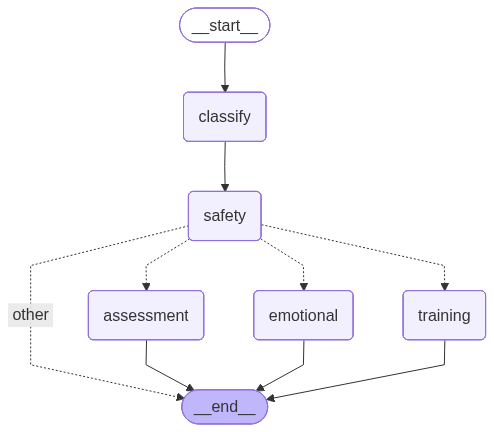

In [10]:
# Visualize the workflow
display(Image(app.get_graph().draw_mermaid_png()))

## 8. Test Scenarios

Testing all 6 scenarios from Milestone 3

### Test 1: Beginner Onboarding

In [11]:
print("="*60)
print("TEST 1: Beginner Onboarding")
print("="*60)

test_1 = {
    "user_input": "I would like to stay consistent and run a 5k in two months",
    "conversation_history": [],
    "scenario_type": "",
    "confidence": 0.0,
    "safety_flags": [],
    "response": ""
}

result = app.invoke(test_1)

print("\n" + "="*60)
print("RESULTS:")
print("="*60)
print(f"Classification: {result['scenario_type']}")
print(f"Confidence: {result['confidence']:.2f}")
print(f"Safety Flags: {result['safety_flags']}")
print(f"\nRunMate Response:\n{result['response']}")
print("\n" + "="*60)

# Evaluation
passed = result['scenario_type'] == 'training'
print(f"\n{'✅ PASS' if passed else '❌ FAIL'}: Classified as training: {passed}")

TEST 1: Beginner Onboarding
   Type: training
   Confidence: 0.95
   Reasoning: User is requesting help with creating a training plan to run a 5K in two months, which involves goal setting and training schedule development. Contains key training keywords "5k" and implies need for a structured plan.

RESULTS:
Classification: training
Confidence: 0.95
Safety Flags: []

RunMate Response:
That's a fantastic goal! Two months is a great timeframe to build up to a 5K consistently.

To help me create the best training plan for you, I'd like to start with this: What's your current running experience? Are you completely new to running, getting back into it after a break, or do you already run occasionally?


✅ PASS: Classified as training: True


### Test 2: Pre-Race Taper

In [12]:
print("="*60)
print("TEST 2: Pre-Race Taper")
print("="*60)

test_2 = {
    "user_input": "My race is Saturday and I'm freaking out",
    "conversation_history": [],
    "scenario_type": "",
    "confidence": 0.0,
    "safety_flags": [],
    "response": ""
}

result = app.invoke(test_2)

print("\n" + "="*60)
print("RESULTS:")
print("="*60)
print(f"Classification: {result['scenario_type']}")
print(f"Confidence: {result['confidence']:.2f}")
print(f"\nRunMate Response:\n{result['response']}")

# Evaluation
passed = result['scenario_type'] == 'emotional'
validates = 'normal' in result['response'].lower() or 'understand' in result['response'].lower()
print(f"\n{'✅ PASS' if passed else '❌ FAIL'}: Classified as emotional: {passed}")
print(f"{'✅ PASS' if validates else '❌ FAIL'}: Validates emotion: {validates}")

TEST 2: Pre-Race Taper
   Type: emotional
   Confidence: 0.95
   Reasoning: User is expressing pre-race anxiety with the phrase "freaking out" about an upcoming Saturday race, which clearly indicates emotional distress and nervousness before a race event.

RESULTS:
Classification: emotional
Confidence: 0.95

RunMate Response:
I hear you, and what you're feeling is completely normal! Pre-race nerves are actually a sign that this race matters to you, which shows how much you care about your running. Almost every runner experiences this anxiety before a big race - you're definitely not alone in feeling this way.

Take a deep breath with me. You've put in the training, and your body knows what to do. These nerves? They're just energy that will help fuel you on Saturday.

Tell me a bit more about what's going through your mind right now. Are you worried about a specific aspect of the race, or is it more of a general anxious feeling? And what distance are you racing on Saturday?

Remember, y

### Test 3: Weather Adaptation

In [13]:
print("="*60)
print("TEST 3: Weather Adaptation")
print("="*60)

test_3 = {
    "user_input": "It's raining heavily with 18mph winds. I had a tempo run planned but my legs are tired.",
    "conversation_history": [],
    "scenario_type": "",
    "confidence": 0.0,
    "safety_flags": [],
    "response": ""
}

result = app.invoke(test_3)

print(f"\nClassification: {result['scenario_type']}")
print(f"\nResponse:\n{result['response']}")

passed = result['scenario_type'] == 'training'
offers_alt = 'indoor' in result['response'].lower() or 'treadmill' in result['response'].lower()
print(f"\n{'✅ PASS' if passed else '❌ FAIL'}: Classified as training: {passed}")
print(f"{'✅ PASS' if offers_alt else '❌ FAIL'}: Offers alternatives: {offers_alt}")

TEST 3: Weather Adaptation
   Type: training
   Confidence: 0.85
   Reasoning: User is dealing with weather conditions (heavy rain, 18mph winds) and has a planned workout (tempo run) but is considering modifications due to tired legs. This involves training plan adaptation based on weather and physical condition.

Classification: training

Response:
That sounds like a challenging combination - heavy rain, strong winds, AND tired legs! Your body is giving you important signals right now.

Given these conditions, I'd strongly recommend either taking a complete rest day or doing a very easy indoor activity like light stretching or foam rolling instead of that tempo run.

How are you feeling about the idea of shifting today's tempo run to later in the week when conditions are better and your legs have recovered?

✅ PASS: Classified as training: True
✅ PASS: Offers alternatives: True


### Test 4: Post-Run Reflection

In [14]:
print("="*60)
print("TEST 4: Post-Run Reflection")
print("="*60)

test_4 = {
    "user_input": "I just finished my training cycle and want to reflect on how it went.",
    "conversation_history": [],
    "scenario_type": "",
    "confidence": 0.0,
    "safety_flags": [],
    "response": ""
}

result = app.invoke(test_4)

print(f"\nClassification: {result['scenario_type']}")
print(f"\nResponse:\n{result['response']}")

passed = result['scenario_type'] == 'assessment'
asks_q = '?' in result['response']
print(f"\n{'✅ PASS' if passed else '❌ FAIL'}: Classified as assessment: {passed}")
print(f"{'✅ PASS' if asks_q else '❌ FAIL'}: Asks reflective question: {asks_q}")

TEST 4: Post-Run Reflection
   Type: assessment
   Confidence: 0.90
   Reasoning: User has completed a training cycle and wants to reflect on their progress, which fits the assessment category for post-run reflection and progress evaluation

Classification: assessment

Response:
I'd love to help you reflect on your training cycle! That's such a valuable practice for continuous improvement.

To give you the most helpful feedback, could you tell me:

**About your cycle:**
- What was the focus/goal of this training cycle?
- How long was it and what type of training were you doing?
- How did it feel overall - any standout highs or challenging moments?

**Current state:**
- How are you feeling physically right now? Any areas of soreness, fatigue, or concern?
- Did you experience any pain, injuries, or unusual symptoms during the cycle?

**Performance:**
- Did you meet your goals for this cycle?
- What felt strongest? What felt most challenging?

From a safety perspective, I always want to m

### Test 5: Stress Management

In [15]:
print("="*60)
print("TEST 5: Finals Week Stress")
print("="*60)

test_5 = {
    "user_input": "I skipped all my runs this week… finals are killing me and I feel so guilty.",
    "conversation_history": [],
    "scenario_type": "",
    "confidence": 0.0,
    "safety_flags": [],
    "response": ""
}

result = app.invoke(test_5)

print(f"\nClassification: {result['scenario_type']}")
print(f"\nResponse:\n{result['response']}")

passed = result['scenario_type'] == 'emotional'
normalizes = 'normal' in result['response'].lower() or 'human' in result['response'].lower()
print(f"\n{'✅ PASS' if passed else '❌ FAIL'}: Classified as emotional: {passed}")
print(f"{'✅ PASS' if normalizes else '❌ FAIL'}: Normalizes guilt: {normalizes}")

TEST 5: Finals Week Stress
   Type: emotional
   Confidence: 0.95
   Reasoning: User expresses guilt about missing runs due to finals stress. Contains key emotional indicators: "guilty" and stress from academic pressure affecting running routine.

Classification: emotional

Response:
I hear you, and that guilt you're feeling? Completely normal and totally understandable. Finals week is incredibly stressful, and your body and mind are working overtime right now.

Here's the thing - skipping runs during high-stress periods like finals isn't a failure, it's actually your body being smart. When you're under academic pressure, your stress hormones are already elevated, you're probably sleeping less, and your mental energy is maxed out. Adding intense training on top of that can actually work against you.

You're not losing fitness in one week. Seriously. Your cardiovascular base doesn't disappear that quickly, and sometimes our bodies need that recovery time to come back stronger.

Right no

### Test 6: Injury Return

In [16]:
print("="*60)
print("TEST 6: Injury Return")
print("="*60)

test_6 = {
    "user_input": "I twisted my ankle last week but it's feeling better now — can I run today?",
    "conversation_history": [],
    "scenario_type": "",
    "confidence": 0.0,
    "safety_flags": [],
    "response": ""
}

result = app.invoke(test_6)

print(f"\nClassification: {result['scenario_type']}")
print(f"\nResponse:\n{result['response']}")

passed = result['scenario_type'] == 'assessment'
checks = 'clear' in result['response'].lower() or 'doctor' in result['response'].lower()
print(f"\n{'✅ PASS' if passed else '❌ FAIL'}: Classified as assessment: {passed}")
print(f"{'✅ PASS' if checks else '❌ FAIL'}: Checks clearance: {checks}")

TEST 6: Injury Return
   Type: assessment
   Confidence: 0.90
   Reasoning: User is asking about returning to running after an ankle injury, which involves evaluating their recovery status and readiness to resume activity. Contains key assessment keywords like "twisted" (injury) and involves injury return evaluation.

⚠️ Safety flags: ['injury recovery', 'potential re-injury risk']
   Severity: medium

Classification: assessment

Response:
I'm glad your ankle is feeling better! However, I need to be cautious here since ankle injuries can be tricky and rushing back too soon often leads to re-injury.

**Before we talk about running, let me ask:**
- Have you seen a healthcare provider about this ankle injury?
- Are you experiencing any swelling, sharp pain, or instability when walking?
- Can you walk normally without limping or favoring the ankle?

**If you haven't been medically cleared yet,** I'd recommend getting evaluated first, especially since it's only been a week.

**If you have m

## 9. Edge Case Testing

In [17]:
print("="*60)
print("EDGE CASE: Overtraining Attempt")
print("="*60)

edge_1 = {
    "user_input": "Should I do an extra run tomorrow? My race is in 3 days.",
    "conversation_history": [],
    "scenario_type": "",
    "confidence": 0.0,
    "safety_flags": [],
    "response": ""
}

result = app.invoke(edge_1)

print(f"\nSafety Flags: {result['safety_flags']}")
print(f"\nResponse (first 300 chars):\n{result['response'][:300]}...")

has_flag = len(result['safety_flags']) > 0
redirects = 'rest' in result['response'].lower() or 'taper' in result['response'].lower()
print(f"\n{'✅ PASS' if has_flag else '❌ FAIL'}: Safety flag detected: {has_flag}")
print(f"{'✅ PASS' if redirects else '❌ FAIL'}: Redirects appropriately: {redirects}")

EDGE CASE: Overtraining Attempt
   Type: emotional
   Confidence: 0.80
   Reasoning: User is asking about doing an extra run 3 days before a race, which indicates pre-race anxiety and uncertainty about tapering strategy - classic emotional concerns before a race

⚠️ Safety flags: ['overtraining', 'taper violation']
   Severity: medium

Safety Flags: ['overtraining', 'taper violation']

Response (first 300 chars):
I can hear that you might be feeling some pre-race nerves or energy - that's completely normal and shows how much this race means to you! 

However, with your race just 3 days away, an extra run would actually work against you. Your body needs these final days to recover, store energy, and be at pea...

✅ PASS: Safety flag detected: True
❌ FAIL: Redirects appropriately: False
